# Training a timm model

In [1]:
from IPython.display import clear_output
!pip install timm
!pip install fastai
!pip install wandb
clear_output()

In [2]:
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("This code is not running in Google Colab.")

Mounted at /content/drive


In [1]:
import os
# Ensure fallback is enabled
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [22]:
# Imports
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

from timm import create_model

from torch.nn.functional import binary_cross_entropy_with_logits
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.metrics import Dice
from fastai import *

import wandb

# Defineing the U-net

In [3]:
class Conv2dBnAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0, act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels,  **conv_args)
        else:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, norm_layer=norm_layer, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, norm_layer=norm_layer, **conv_args)

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [5]:
class UnetDecoder(nn.Module):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            norm_layer=nn.BatchNorm2d,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(channels, channels, scale_factor=1.0, norm_layer=norm_layer)
        else:
            self.center = nn.Identity()

        in_channels = [in_chs + skip_chs for in_chs, skip_chs in zip(
            [encoder_channels[0]] + list(decoder_channels[:-1]),
            list(encoder_channels[1:]) + [0])]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(out_channels[-1], final_channels, kernel_size=(1, 1))

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [6]:
class Unet(nn.Module):
    """Unet is a fully convolution neural network for image semantic segmentation
    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        num_classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        center: if ``True`` add ``Conv2dReLU`` block on encoder head
    NOTE: This is based off an old version of Unet in https://github.com/qubvel/segmentation_models.pytorch
    """

    def __init__(
            self,
            backbone='resnet50',
            backbone_kwargs=None,
            backbone_indices=None,
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            in_chans=1,
            num_classes=5,
            center=False,
            norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone, features_only=True, out_indices=backbone_indices, in_chans=in_chans,
            pretrained=True, **backbone_kwargs)
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x

# Defineing helper functions

In [15]:
data_path = Path('data/')

def get_data(size, tfms=None, bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255),
                 FlipItem(p=0.5),
                 Rotate(max_deg=180, p=0.5),
                 Zoom(max_zoom=1.2, min_zoom=0.5, p=0.5, pad_mode='reflection')]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=RandomSplitter(valid_pct=0.1,seed=2021),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files, get_y=lambda o:str(o).replace('images','labels'))
    return db.dataloaders(source=data_path/'train'/'images',bs=bs)

In [ ]:
def get_test_data(size, tfms=None, bs=64):
    if not tfms:
        tfms = [IntToFloatTensor(div_mask=255)]
    db = DataBlock(blocks=(ImageBlock(),MaskBlock()),
                   splitter=GrandparentSplitter(train_name='train',valid_name='val'),
                   batch_tfms=tfms,
                   item_tfms=[Resize(size)],
                   get_items=get_image_files, get_y=lambda o:str(o).replace('images','labels'))
    return db.dataloaders(source=data_path/'test'/'images',bs=bs)

In [16]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1e-06, alpha=1., reduction='mean'):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth, reduction)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [17]:
wandb_callback = WandbCallback(
    log='all',
    log_preds=False,
    log_preds_every_epoch=False,
    log_model=False,
    model_name=None,
    log_dataset=False,
    dataset_name=None,
    valid_dl=None,
    n_preds=36,
    seed=12345,
    reorder=True
)

# Training

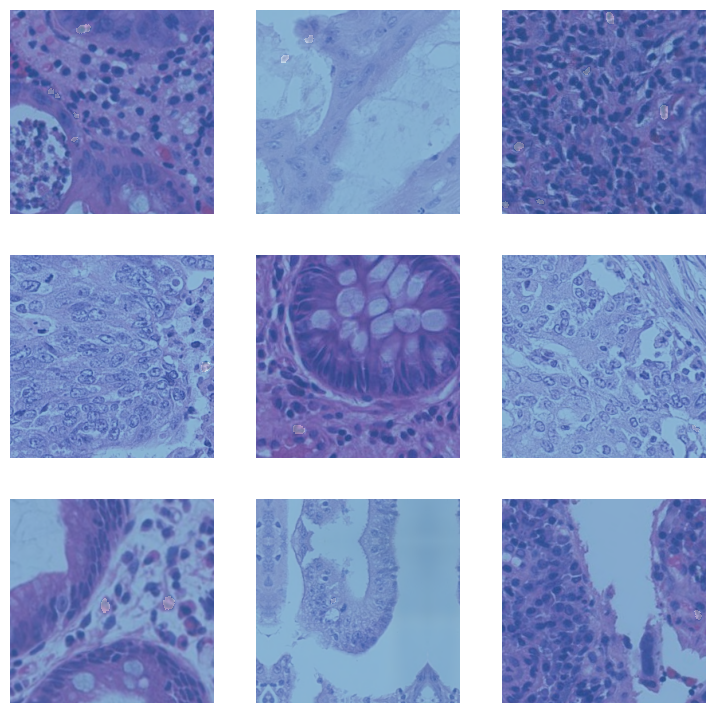

In [18]:
dls = get_data(size=256,bs=32)
dls.show_batch(max_n=9)

In [19]:
metrics = Dice()
loss_func = CombinedLoss()

In [20]:
# Learner with combined loss and Dice metric
learn = Learner(dls, Unet(backbone='resnet50.a1_in1k', decoder_use_batchnorm=True, in_chans=3, num_classes=2),
                loss_func=CombinedLoss(),
                metrics=[metrics], cbs=[SaveModelCallback(monitor='dice', fname='best_model', comp=np.greater),
                EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5)])

SuggestedLRs(valley=0.001737800776027143)

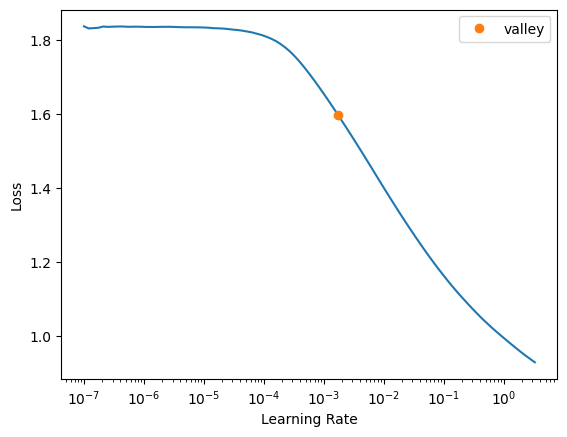

In [15]:
learn.lr_find()

# Load in model and run connnected components analysis

In [27]:
model_path = 'models/best_model_resnet50_48.pth'
data_path = 'data/train'
model = Unet(in_chans=3, num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
model.eval()

Unet(
  (encoder): FeatureListNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,